<BarContainer object of 51 artists>

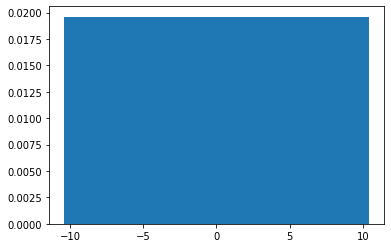

In [3]:
import numpy as np
import torch
from matplotlib import pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

vmin, vmax = -10, 10   # 지지집합의 범위 ( -10 ~ 10 ) : 보상 범위
nsup = 51              # 지지집합의 요소 개수
# 지지집합 생성
support = np.linspace(vmin, vmax, nsup)

# 확률 생성 ( 초기값 균등 분포 )
probs = np.ones(nsup)
probs /= probs.sum()
z3 = torch.from_numpy(probs).float()
plt.bar(support, probs)

In [4]:
# 확률 분포 갱신 함수
# r : 보상, support : 지지집합, probs : 확률, lim : 지지집합 범위, gamma : 할인 계수
def update_dist(r, support, probs, lim=(-10, 10), gamma=0.8):
# 변수 설정
    # nsup : 지지 집합 크기, vmin, vmax : 지지 집합의 최솟값, 최댓값, dz : 지지 집합의 공차
    nsup = probs.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax - vmin)/(nsup-1.)
    
    # 보상에 해당하는 인덱스 추출
    bj = np.round((r-vmin)/dz)
    bj = int(np.clip(bj, 0, nsup-1))
    
    # 갱신할 분포
    m = probs.clone()
    
    # bj의 왼쪽 값의 확률 갱신 
    # gamma의 값이 클수록 갱신된 bj의 값이 커짐
    j = 1
    for i in range(bj, 1, -1):
        m[i] += np.power(gamma, j) * m[i-1]
        j += 1
        
    # bj의 오른쪽 값의 확률 갱신
    j = 1
    for i in range(bj, nsup-1, 1):
        m[i] += np.power(gamma, j) * m[i+1]
        j += 1
        
    # 확률의 합이 1이 되도록 조정
    m /= m.sum()
    
    return m

In [17]:
# 분포 DQN
# x : 상태 벡터, theta : 신경망 매개변수, aspace : 동작의 수
def dist_dqn(x, theta, aspace=3):
    # 신경망의 차원 설정
    dim0, dim1, dim2, dim3 = 128, 100, 25, 51
    
    # theta를 층별로 분해
    t1 = dim0 * dim1
    t2 = dim2 * dim1
    theta1 = theta[0:t1].reshape(dim0, dim1)
    theta2 = theta[t1:t1+t2].reshape(dim1, dim2)
    
    # 신경망 통과
    l1 = x @ theta1
    l1 = torch.selu(l1)
    l2 = l1 @ theta2
    l2 = torch.selu(l2)
    l3 = []
    # 마지막 층은 동작마다 신경망 계산
    for i in range(aspace):
        # i번째 동작에 해당하는 신경망 매개변수 추출
        step = dim2 * dim3
        theta5_dim = t1 + t2 + i * step
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2, dim3)
        # 신경망 통과 후 l3에 저장
        l3_ = l2 @ theta5
        l3.append(l3_)
        
    # 차원 증가 후 softmax로 확률을 반환
    l3 = torch.stack(l3, dim=1)
    l3 = torch.nn.functional.softmax(l3, dim=2)
    
    return l3.squeeze()

In [21]:
# 목표 분포 계산
def get_target_dist(dist_batch, action_batch, reward_batch, support, lim=(-10,10), gamma=0.8):
    # 변수 설정
    # nsup : 지지 집합 크기, vmin, vmax : 지지 집합의 최솟값, 최댓값, dz : 지지 집합의 공차, target_dist_batch : 목표 분포
    nsup = support.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    
    # 배치 크기만큼 목표 분포 갱신
    for i in range(dist_batch.shape[0]):
        # i번째 분포에서 액션에 해당하는 분포와 보상 추출
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        
        # r != -1 : 마지막 상태
        # 마지막 상태에서는 퇴화 확률 분포
        if r != -1:
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj, 0, nsup-1))
            target_dist[bj] = 1.
        # 진행 상태에서는 보상을 통해 분포 갱신
        else:
            target_dist = update_dist(r, support, dist, lim=lim, gamma=gamma)
            
        target_dist_batch[i, action, ] = target_dist
        
    return target_dist_batch

In [22]:
# 손실 함수 ( 교차 엔트로피 손실 함수)
def lossfn(x, y):
    loss = torch.Tensor([0.])
    loss.requires_grad = True
    
    # 배치 크기만큼 계산
    for i in range(x.shape[0]):
        loss_= -1 * torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0)
        loss = loss + loss_
        
    return loss

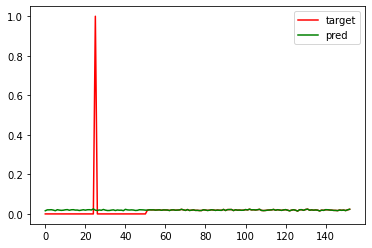

In [27]:
# test
aspace = 3                                    # 동작 개수
tot_params = 128*100 + 25*100 + aspace*25*51 # 신경망 매개변수 수
theta = torch.randn(tot_params)/10.           # 신경망 매개변수 랜덤 초기화
theta.requires_grad = True
theta_2 = theta.detach().clone()              # 목표 신경망 매개변수

vmin, vmax = -10, 10                   # 지지집합의 최솟값, 최댓값
gamma = 0.9                            # 할인 계수
lr = 0.00001                           # 학습률
update_rate = 75                       # 주 신경망 갱신 간격
support = torch.linspace(-10, 10, 51)  # 지지집합 생성 ( 최솟값, 최댓값, 개수 )
state = torch.randn(2, 128)/10.        # 상태 2개 랜덤 초기화 ( 시험용 )
action_batch = torch.Tensor([0, 2])    # 액션 배치
reward_batch = torch.Tensor([0, 10])   # 보상 배치
losses = []                            # 손실
pred_batch = dist_dqn(state, theta, aspace=aspace) # 예측 배치
target_dist = get_target_dist(pred_batch, action_batch, reward_batch, support, lim=(vmin, vmax), gamma = gamma)  # 목표 분산

# 시각화
plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()), color='red', label='target')
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()), color='green', label='pred')
plt.legend()

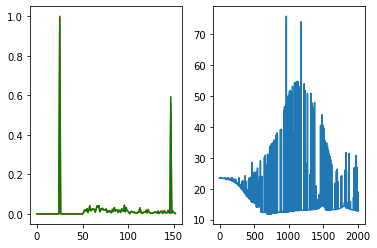

In [33]:
# 훈련
for i in range(1000):
    # 잡음을 추가한 보상 배치 생성
    reward_batch = torch.Tensor([0, 8]) + torch.randn(2)/10.0
    # 분포 예측 ( 주 신경망 )
    pred_batch = dist_dqn(state, theta, aspace=aspace)
    # 분포 예측 ( 목표망 )
    pred_batch2 = dist_dqn(state, theta_2, aspace=aspace)
    # 목표 분포
    target_dist = get_target_dist(pred_batch2, action_batch, reward_batch, support, lim=(vmin,vmax), gamma=gamma)
    # 손실 계산
    loss = lossfn(pred_batch, target_dist.detach())
    losses.append(loss.item())
    loss.backward()
    
    # 경사 하강법으로 주 신경망 갱신
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True
    
    # 목표망 업데이트
    if i % update_rate == 0:
        theta_2 = theta.detach().clone()
        
# 시각화
fig, ax = plt.subplots(1, 2)
ax[0].plot((target_dist.flatten(start_dim=1)[0].data.numpy()), color='red', label='target')
ax[0].plot((pred_batch.flatten(start_dim=1)[0].data.numpy()), color='green', label='pred')
ax[1].plot(losses)

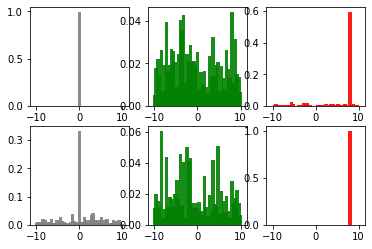

In [44]:
# 학습된 동작 가치 분포의 시각화
tpred = pred_batch
cs = ['gray', 'green', 'red']
num_batch = 2
labels = ['Action {}'.format(i,) for i in range(aspace)]
fig, ax = plt.subplots(nrows=num_batch, ncols=aspace)

for j in range(num_batch):
    for i in range(tpred.shape[1]):
        ax[j,i].bar(support.data.numpy(), tpred[j, i, :].data.numpy(), label='Action {}'.format(i), alpha=0.9, color=cs[i])

In [46]:
# 상태 전처리
def preproc_state(state):
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state, dim=1)
    return p_state

In [47]:
# 동작 선택
def get_action(dist, support):
    actions = []
    # 배치 크기만큼 반복
    for b in range(dist.shape[0]):
        # 각 동장에 대한 기댓값 계산
        expectations = [support @ dist[b, a, :] for a in range(dist.shape[1])]
        # 기댓값이 가장 큰 동작 선택
        action = int(np.argmax(expectations))
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [49]:
# 게임 학습을 위해 초기화
import gym
from collections import deque

env = gym.make('Freeway-ram-v0')             # 환경 생성
aspace = 3                                   # 동작 개수
env.env.get_action_meanings()
vmin, vmax = -10, 10                         # 지지집합의 최솟값, 최댓값
replay_size = 200                            # 재현 크기
batch_size = 50                              # 배치 크기
nsup = 51                                    # 지지집합 개수
dz = (vmax-vmin)/(nsup-1)                    # 지지집합 공차
support = torch.linspace(vmin, vmax, nsup)   # 지지집합 생성

replay = deque(maxlen=replay_size)           # 경험 재현 목록
lr = 0.0001                                  # 학습률
gamma = 0.1                                  # 할인 계수
epochs = 13000                               # 반복 학습 횟수
eps = 0.20                                   # 엡실론 : 탐험에 사용
eps_min = 0.05                               # 엡실론 최솟값
priority_level = 5                           # 우선순위가 높은 경험 복사본 개수
update_freq = 25                             # 목표망 갱신 간격

tot_params = 128*100 + 25*100 + asapce*25*51 # 신경망 매개변수 개수
theta = torch.randn(tot_params)/10.           # 주 신경망 매개변수
theta.requires_grad = True
theta_2 = theta.detach().clone()              # 목표망 매개변수

losses = []                                   # 손실값
cum_rewards = []                              # 게임 승리 배열 ( 승리 시 1 추가 )
renders = []
state = preproc_state(env.reset())

UnregisteredEnv: No registered env with id: Freeway-ram-v0

In [ ]:
from random import shuffle

# epochs만큼 훈련 반복
for i in range(epochs):
    # 주 신경망으로 분산 예측
    pred = dist_dqn(state, theta, asapce=aspace)
    
    # 엡실론 전략으로 동작 선택
    if i < replay_size or np.random.rand(1) < eps:
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.unsqueeze(dim=0).detach(), support).item()
        
    # 환경 실행 및 상태 전처리
    state2, reward, done, info = env.step(action)
    state2 = preproc_state(state2)
    
    # 얻은 보상이 1이면 게임 승리, 배열에 추가
    if reward == 1: cum_rewards.append(1)

    # 환경에서 얻은 보상 처리
    reward = 10 if reward == 1 else reward
    reward = -10 if done else reward
    reward = -1 if reward == 0 else reward
    
    # 경험을 튜플로 저장해서 재현 목록에 추가
    exp = (state, action, reward, state2)
    repaly.append(exp)
    
    # 게임 승리 시 우선순위가 높은 경험으로 간주하고 priority_level만큼 재현 목록에 추가 ( 경험 증폭 )
    if reward == 10:
        for e in range(priority_level):
            replay.append(exp)
            
    # 재현 목록 섞고, 상태 전이
    shuffle(replay)
    state = state2
    
    # 재현 목록이 다 차면 훈련 시작
    if len(replay) === replay_size:
        # 재현 목록에서 랜덤 배치 추출
        indx = np.random.randint(low=0, high=len(replay), size=batch_size)
        exps = [replay[j] for j in indx]
        
        # 배치를 통해 상태, 동작, 보상, 다음 상태 배열 생성
        state_batch = torch.stack([ex[0] for ex in exps], dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps], dim=1).squeeze()
        
        # 위에서 얻은 상태와 다음 상태 배치를 통해서 분포 예측, 목표 분포 생성
        pred_batch = dist_dqn(state_batch.detach(), theta_2, aspace=aspace)
        pred2_batch = dist_dqn(state2_batch.detach(), theta_2, asapce=aspace)
        target_dist = get_target_dist(pred2_batch, action_batch, reward_batch, support, lim=(vmin,vmax), gamma=gamma)
        
        # 손실 계산
        loss = lossfn(pred_batch, target_dist.detach())
        losses.append(loss.item())
        loss.backword()
        
        # 경사 하강법으로 주 신경망 갱신
        with torch.no_grad():
            theta -= lr * theta.grad
        theta.requires_grad = True
        
    # update_freq 마다 목표망 갱신
    if i % update_freq == 0:
        theta_2 = theta.detach().clone()
        
    # 엡실론 조절
    if i > 100 and eps > eps_min:
        dec = 1./np.log2(i)
        dec /= le3
        eps -= dec
        
    # 게임 종료시 환경 초기화
    if done:
        state = preproc_state(env.reset())
        done = False